In [1]:
import time
from coffea import nanoevents, util
import hist
import coffea.processor as processor
import awkward as ak
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import glob as glob
import re
import itertools
import vector as vec
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoAODSchema
# for applying JECs
from coffea.lookup_tools import extractor
from coffea.jetmet_tools import JECStack, CorrectedJetsFactory

# JERC script for txt files

In [2]:
def ApplyJetCorrections(jec_tag, jec_tag_data, jer_tag, isMC, era=None,
                        corr_type=None, do_factorized_jec_unc=False):
    ## example input
    # jec_tag="Summer19UL16APV_V7_MC"
    # jec_tag_data={
    #     "RunB-ver1": "Summer19UL16APV_RunBCD_V7_DATA",
    #     "RunB-ver2": "Summer19UL16APV_RunBCD_V7_DATA",
    #     "RunC": "Summer19UL16APV_RunBCD_V7_DATA",
    #     "RunD": "Summer19UL16APV_RunBCD_V7_DATA",
    #     "RunE": "Summer19UL16APV_RunEF_V7_DATA",
    #     "RunF": "Summer19UL16APV_RunEF_V7_DATA",
    # }
    # jer_tag = "Summer20UL16APV_JRV3_MC"
    
    extract = extractor()
    if (isMC):
        #For MC
        extract.add_weight_sets([
            '* * data/JEC/{0}/{0}_L1FastJet_AK4PFchs.txt'.format(jec_tag),
            '* * data/JEC/{0}/{0}_L2Relative_AK4PFchs.txt'.format(jec_tag),
            '* * data/JEC/{0}/{0}_L3Absolute_AK4PFchs.txt'.format(jec_tag),
            '* * data/JEC/{0}/{0}_UncertaintySources_AK4PFchs.junc.txt'.format(jec_tag),
            '* * data/JEC/{0}/{0}_Uncertainty_AK4PFchs.junc.txt'.format(jec_tag),
        ])

        if jer_tag:
            extract.add_weight_sets([
            '* * data/JER/{0}/{0}_PtResolution_AK4PFchs.jr.txt'.format(jer_tag),
            '* * data/JER/{0}/{0}_SF_AK4PFchs.jersf.txt'.format(jer_tag)])
    else:       
        #For data, make sure we don't duplicate
        tags_done = []
        for run, tag in jec_tag_data.items():
            if not (tag in tags_done):
                extract.add_weight_sets([
                '* * data/JEC/{0}/{0}_L1FastJet_AK4PFchs.txt'.format(tag),
                '* * data/JEC/{0}/{0}_L2Relative_AK4PFchs.txt'.format(tag),
                '* * data/JEC/{0}/{0}_L3Absolute_AK4PFchs.txt'.format(tag),
                '* * data/JEC/{0}/{0}_L2L3Residual_AK4PFchs.txt'.format(tag),
                ])
                tags_done += [tag]
                
    extract.finalize()
    evaluator = extract.make_evaluator()
    
    if (isMC):
        jec_names = [
            '{0}_L1FastJet_AK4PFchs'.format(jec_tag),
            '{0}_L2Relative_AK4PFchs'.format(jec_tag),
            '{0}_L3Absolute_AK4PFchs'.format(jec_tag),
            '{0}_Uncertainty_AK4PFchs'.format(jec_tag)]
        if do_factorized_jec_unc:
            for name in dir(evaluator):
               #factorized sources
               if '{0}_UncertaintySources_AK4PFchs'.format(jec_tag) in name:
                    jec_names.append(name)
        if jer_tag: 
            jec_names.extend(['{0}_PtResolution_AK4PFchs'.format(jer_tag),
                              '{0}_SF_AK4PFchs'.format(jer_tag)])

    else:
        jec_names={}
        for run, tag in jec_tag_data.items():
            jec_names[run] = [
                '{0}_L1FastJet_AK4PFchs'.format(tag),
                '{0}_L3Absolute_AK4PFchs'.format(tag),
                '{0}_L2Relative_AK4PFchs'.format(tag),
                '{0}_L2L3Residual_AK4PFchs'.format(tag),]
    if isMC:
        jec_inputs = {name: evaluator[name] for name in jec_names}
    else:
        jec_inputs = {name: evaluator[name] for name in jec_names[era]}
    
    jec_stack = JECStack(jec_inputs)
    name_map = jec_stack.blank_name_map
    name_map['JetPt'] = 'pt'
    name_map['JetEta'] = 'eta'
    name_map['JetPhi'] = 'phi'
    name_map['JetMass'] = 'mass'
    name_map['Rho'] = 'rho'
    name_map['JetA'] = 'area'
    name_map['ptGenJet'] = 'pt_gen'
    name_map['ptRaw'] = 'pt_raw'
    name_map['massRaw'] = 'mass_raw'
    name_map['METpt'] = 'pt'
    name_map['METphi'] = 'phi'
    name_map['UnClusteredEnergyDeltaX'] = 'MetUnclustEnUpDeltaX'
    name_map['UnClusteredEnergyDeltaY'] = 'MetUnclustEnUpDeltaY'
    if corr_type=='met': return CorrectedMETFactory(name_map)
    return CorrectedJetsFactory(name_map, jec_stack)

# JERC to be tested

In [3]:
jec_tag="Summer19UL17_V5_MC"
jec_tag_data={
    "RunB": "Summer19UL17_RunB_V5_DATA",
    "RunC": "Summer19UL17_RunC_V5_DATA",
    "RunD": "Summer19UL17_RunD_V5_DATA",
    "RunE": "Summer19UL17_RunE_V5_DATA",
    "RunF": "Summer19UL17_RunF_V5_DATA",
}
jer_tag = "Summer19UL17_JRV2_MC"

## File for testing JERC

In [4]:
import uproot
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

filename = 'root://cmsxrootd.fnal.gov//store/mc/Run3Summer22EENanoAODv11/QCD_PT-15to7000_TuneCP5_13p6TeV_pythia8/NANOAODSIM/EpsilonPU_castor_126X_mcRun3_2022_realistic_postEE_v1-v1/50000/048073fd-af00-4385-abbf-d1599b69c268.root'
# filename = 'root://dcache-cms-xrootd.desy.de:1094//store/data/Run2017B/MET/NANOAOD/UL2017_MiniAODv2_NanoAODv9-v1/70000/FA64699A-4177-F641-A4A7-1D03AAD4F75A.root'
isMC=True
era = None

events = NanoEventsFactory.from_root(
    filename,
    schemaclass=NanoAODSchema.v6,
    #metadata={'dataset':"MET"}
).events()

In [5]:
Jets = events.Jet
Jets["p4"]    = ak.with_name(Jets[["pt", "eta", "phi", "mass"]],"PtEtaPhiMLorentzVector")
if (isMC):
    Jets["matched_gen_0p2"] = Jets.nearest(events.GenJet, threshold=0.2)
print("Jet pt in NanoAOD: ", Jets.pt)

if "Rho" in events.fields:
    Jets["rho"] = ak.broadcast_arrays(events.Rho.fixedGridRhoFastjetAll, Jets.pt)[0]
else:
    Jets["rho"] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll, Jets.pt)[0]

Jets["pt_raw"] = (1 - Jets.rawFactor) * Jets.pt
Jets["mass_raw"] = (1 - Jets.rawFactor) * Jets.mass
Jets["pt"] = Jets.pt_raw
Jets["mass"] = Jets.mass_raw
Jets["p4","pt"] = Jets.pt_raw
Jets["p4","mass"] = Jets.mass_raw
if (isMC):
    Jets["pt_gen"] = ak.values_astype(ak.fill_none(Jets.matched_gen_0p2.pt, 0), np.float32)
    
print("Un-corrected Jet pt: ", Jets.pt)

Jet pt in NanoAOD:  [[81.8, 46.7, 42.7], [140, 134], ... 151, 51.2, 17.3], [1.4e+03, 1.23e+03, 224]]
Un-corrected Jet pt:  [[76.3, 39.4, 32.3], [132, 128], ... 139, 44.3, 16.1], [1.31e+03, 1.16e+03, 210]]


# Checking outputs for txt

In [6]:
CleanedJets = ApplyJetCorrections(jec_tag=jec_tag, jec_tag_data=jec_tag_data, jer_tag=jer_tag,
                                  isMC=isMC, era=era, corr_type=None,
                                  do_factorized_jec_unc=False).build(Jets, lazy_cache=events.caches[0])
CleanedJets_nosmear = ApplyJetCorrections(jec_tag=jec_tag, jec_tag_data=jec_tag_data, jer_tag=None,
                                  isMC=isMC, era=era, corr_type=None,
                                  do_factorized_jec_unc=False).build(Jets, lazy_cache=events.caches[0])

In [7]:
print("Corrected Jet pt: ", CleanedJets.pt)
print("Corrected Jet pt with no smearing: ", CleanedJets_nosmear.pt)

Corrected Jet pt:  [[84.2, 45, 38], [141, 136], ... 356, 154, 50.9, 17.9], [1.5e+03, 1.24e+03, 225]]


Corrected Jet pt with no smaering:  [[82.1, 45.3, 38.3], [141, 135], ... 153, 50.9, 18.3], [1.47e+03, 1.24e+03, 226]]


In [9]:
import mplhep
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-pbbqol5m because the default path (/uscms/home/gagarwal/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [10]:
ak.max(Jets.pt), ak.max(CleanedJets.pt)

(7710.044, 7864.5737)

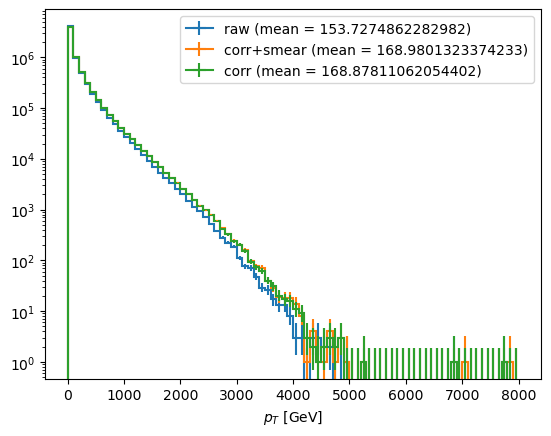

In [11]:
pt_axis = hist.axis.Regular(80, 0, 8000, name="pt", label=r"$p_{T}$ [GeV]")
pt_old = hist.Hist(pt_axis, storage="weight", name = "Events")
pt_new = hist.Hist(pt_axis, storage="weight", name = "Events")
pt_nosmear = hist.Hist(pt_axis, storage="weight", name = "Events")
pt_old.fill(ak.flatten(Jets.pt))
pt_new.fill(ak.flatten(CleanedJets.pt))
pt_nosmear.fill(ak.flatten(CleanedJets_nosmear.pt))
pt_old.plot(label='raw (mean = {})'.format(ak.mean(Jets.pt)))
pt_nosmear.plot(label='corr (mean = {})'.format(ak.mean(CleanedJets_nosmear.pt)))
pt_new.plot(label='corr+smear (mean = {})'.format(ak.mean(CleanedJets.pt)))
plt.yscale('log')
plt.legend()

## Now for JSON file

Implementation of JEC from : https://github.com/cms-jet/JECDatabase/blob/master/scripts/JERC2JSON/minimalDemo.py

In [12]:
import correctionlib._core as core

In [ ]:
cset = core.CorrectionSet.from_file("UL2017/jet_jerc.json.gz")
